## ENSEMBLE MODEL (LR + SVM + XGB + LSTM)

In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split, cross_val_score

# Load Logistic Regression model and vectorizer
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

# Load SVM model and vectorizer
with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

# Load XGBoost model, vectorizer, and label encoder
with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

# Load LSTM model, tokenizer, and label encoder
lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')

# Check if 'cleaned_text' column exists
if 'cleaned_text' not in data.columns:
    raise ValueError("The dataset must have a 'cleaned_text' column.")

# Remove rows with missing values in 'cleaned_text'
data.dropna(subset=['cleaned_text'], inplace=True)

# Split features and target
X_test = data['cleaned_text']
y_test = data['mental_health_issue']

# Encode target labels
y_test = label_encoder.transform(y_test)

# Process the text for each model
X_test_lr = lr_vectorizer.transform(X_test)  # Logistic Regression vectorizer
X_test_svm = svm_vectorizer.transform(X_test)  # SVM vectorizer
X_test_xgb = tfidf_vectorizer.transform(X_test)  # XGBoost vectorizer
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)  # LSTM tokenizer

# Pad sequences for LSTM
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get predictions from the base models
lr_predictions_proba = lr_model.predict_proba(X_test_lr)  # Logistic Regression probabilities
svm_predictions_proba = svm_model.predict_proba(X_test_svm)  # SVM probabilities
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)  # XGBoost probabilities
lstm_predictions_proba = lstm_model.predict(X_test_lstm)  # LSTM probabilities

# Stack the predictions of all models to create the feature matrix for the meta-learner
stacked_features = np.hstack((lr_predictions_proba, svm_predictions_proba, xgb_predictions_proba, lstm_predictions_proba))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    stacked_features, y_test, test_size=0.2, random_state=42, stratify=y_test
)

# Train the meta-learner (SVM as the meta-learner)
meta_learner = SVC(probability=True)  # Enable probability predictions for SVM
# Fit the model on training data
meta_learner.fit(X_train, y_train)

# Save the trained meta-learner
with open('meta_learner_svm.pkl', 'wb') as file:
    pickle.dump(meta_learner, file)

# Load the pre-trained meta-learner (if needed)
with open('meta_learner_svm.pkl', 'rb') as file:
    meta_learner = pickle.load(file)

# Predict using the meta-learner
final_predictions = meta_learner.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, final_predictions)
report = classification_report(y_test, final_predictions, target_names=label_encoder.classes_)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", report)

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, final_predictions))


# Calculate the mean and standard deviation of validation accuracies
cross_val_accuracies = cross_val_score(
    meta_learner, X_test, y_test, cv=5, scoring='accuracy'
)

mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")

581/581 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step
Accuracy: 97.47%
Classification Report:
               precision    recall  f1-score   support

     anxiety       0.98      0.96      0.97       400
     bipolar       0.96      0.89      0.92       388
  depression       0.95      0.96      0.96       392
      normal       0.98      1.00      0.99      2136
        ptsd       0.96      0.97      0.97       397

    accuracy                           0.97      3713
   macro avg       0.97      0.96      0.96      3713
weighted avg       0.97      0.97      0.97      3713

Confusion Matrix:
 [[ 386    1    6    2    5]
 [   1  344    5   33    5]
 [   7    4  376    1    4]
 [   0    6    1 2128    1]
 [   1    2    6    3  385]]
Cross-Validation Accuracies: [0.9717362  0.96904441 0.96904441 0.97708895 0.97708895]
Mean Validation Accuracy: 97.28%
Validation Accuracy Std Dev: 0.36%


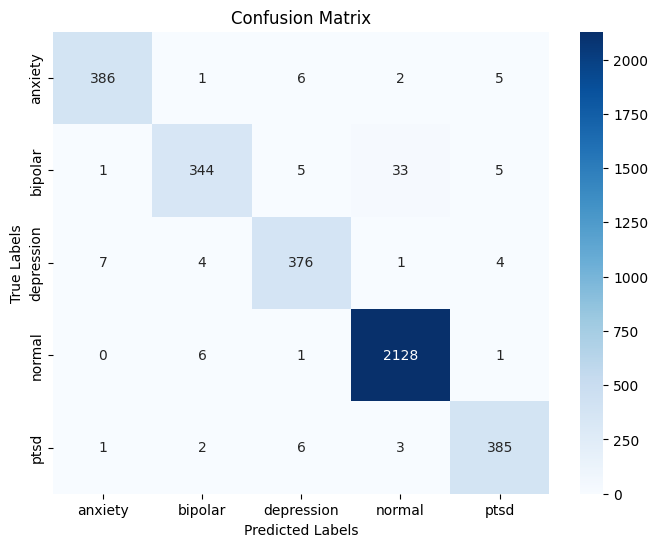

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, final_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


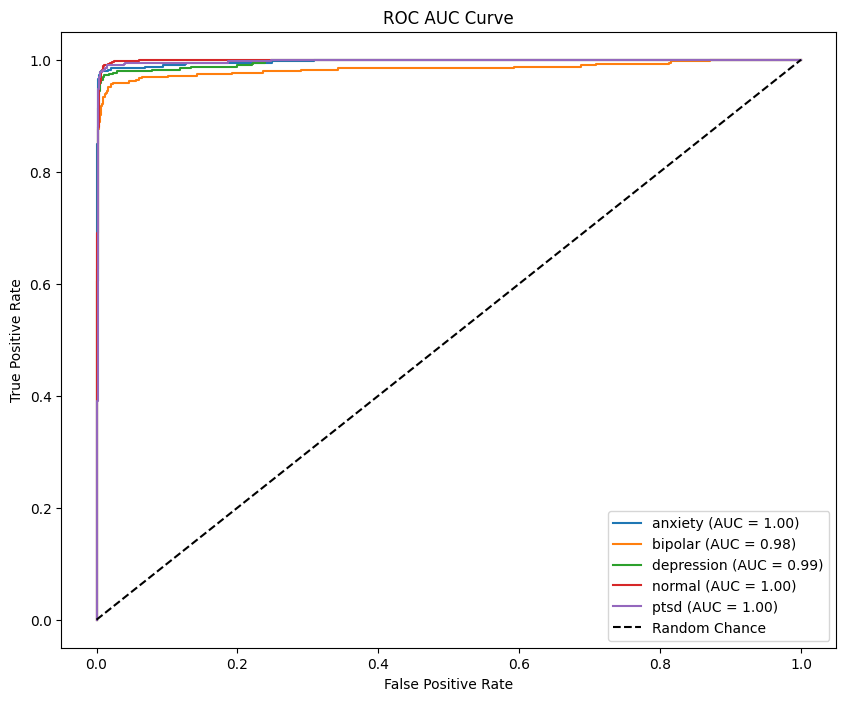

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))

# Calculate probabilities for the test set only
final_predictions_proba = meta_learner.predict_proba(X_test) # Changed stacked_features to X_test

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], final_predictions_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()